## Import Semua Packages/Library yang Digunakan

In [1]:
# Basic Python libraries
import os
import random
import shutil
import zipfile
import json

# Data manipulation libraries
import numpy as np
import pandas as pd

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNet, DenseNet121
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image processing libraries
import cv2
from PIL import Image
from skimage import io, img_as_ubyte
from skimage.transform import rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split

2025-07-20 09:38:52.893649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753004333.119705      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753004333.188385      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Proyek Klasifikasi Gambar: [Dog Breeds Image Dataset]
- **Nama:** Junpito Salim
- **Email:** junpitosalim@gmail.com
- **ID Dicoding:** junpito

## Data Preparation

### Data Loading

In [2]:
dataset_path = '/kaggle/input/vegetable-image-dataset/Vegetable Images/train'
test_dataset_path = '/kaggle/input/vegetable-image-dataset/Vegetable Images/test'

In [3]:
from pathlib import Path

# Hitung jumlah file dalam path dataset
file_count = len(list(Path(dataset_path).rglob('*')))

# Tampilkan jumlah file
print(f"Jumlah file dalam path {dataset_path}: {file_count}")

Jumlah file dalam path /kaggle/input/vegetable-image-dataset/Vegetable Images/train: 15015


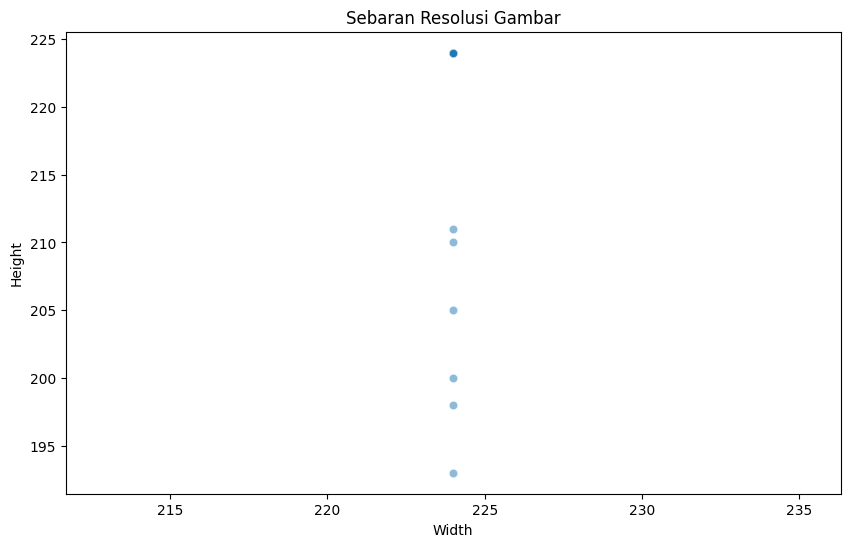

In [4]:
# Inisialisasi list untuk menyimpan resolusi
image_resolutions = []

# Loop melalui semua folder dan file di dalam dataset_path
for subdir, dirs, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(subdir, file)
        
        # Memastikan hanya file gambar yang diambil
        try:
            with Image.open(file_path) as img:
                width, height = img.size
                image_resolutions.append((width, height))
        except:
            # Lewatkan file yang bukan gambar
            continue

# Memisahkan width dan height untuk visualisasi
widths = [w for w, h in image_resolutions]
heights = [h for w, h in image_resolutions]

# Visualisasi sebaran resolusi dengan seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=widths, y=heights, alpha=0.5)
plt.title('Sebaran Resolusi Gambar')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

### Data Preprocessing

#### Split Dataset

In [5]:
def get_classes_automatically(dataset_path):
    """
    Deteksi class secara otomatis dari nama folder
    """
    dataset_path = Path(dataset_path)
    classes = []
    
    # Ambil nama folder sebagai class
    for folder in dataset_path.iterdir():
        if folder.is_dir():
            classes.append(folder.name)
    
    # Urutkan alfabetis untuk konsistensi
    classes.sort()
    
    print(f" Ditemukan {len(classes)} kelas:")
    for i, class_name in enumerate(classes):
        print(f"  {i}: {class_name}")
    
    return classes

def save_class_mapping(classes, save_path="class_mapping.json"):
    """
    Simpan mapping class ke file JSON
    """
    mapping = {
        'classes': classes,
        'class_to_idx': {cls: i for i, cls in enumerate(classes)},
        'idx_to_class': {i: cls for i, cls in enumerate(classes)},
        'num_classes': len(classes)
    }
    
    with open(save_path, 'w') as f:
        json.dump(mapping, f, indent=2)
    
    print(f" Mapping disimpan ke: {save_path}")
    return mapping

def load_class_mapping(mapping_path="class_mapping.json"):
    """
    Load mapping dari file JSON
    """
    with open(mapping_path, 'r') as f:
        mapping = json.load(f)
    
    print(f" Mapping loaded dari: {mapping_path}")
    return mapping

In [6]:
def create_generators_auto(dataset_path, img_height=224, img_width=224, 
                          batch_size=32, validation_split=0.2):
    """
    Buat generator dengan class detection otomatis
    """
    # Deteksi class otomatis
    classes = get_classes_automatically(dataset_path)
    
    # Simpan mapping
    mapping = save_class_mapping(classes)
    
    # Buat generator
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=validation_split
    )
    
    # Training generator
    train_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        classes=classes,  # Gunakan class yang terdeteksi
        class_mode='categorical',
        subset='training'
    )
    
    # Validation generator
    val_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        classes=classes,
        class_mode='categorical',
        subset='validation'
    )
    
    return train_generator, val_generator, mapping

In [7]:
train_generator, val_generator, mapping = create_generators_auto(
    dataset_path=dataset_path,
    img_height=224,
    img_width=224,
    batch_size=256
)

 Ditemukan 15 kelas:
  0: Bean
  1: Bitter_Gourd
  2: Bottle_Gourd
  3: Brinjal
  4: Broccoli
  5: Cabbage
  6: Capsicum
  7: Carrot
  8: Cauliflower
  9: Cucumber
  10: Papaya
  11: Potato
  12: Pumpkin
  13: Radish
  14: Tomato
 Mapping disimpan ke: class_mapping.json
Found 12000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


## Modelling

In [8]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.18.0
Num GPUs Available: 1


In [9]:
# Load DenseNet121 without top layers
base_model = DenseNet121(weights='imagenet', include_top=False
                         , input_shape=(224, 224, 3))
base_model.trainable = False

# Build the model
model = Sequential()
model.add(base_model)

# Add more layers after DenseNet121
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='softmax'))

# Now build the model
model.build((None, 224, 224, 3))

# Model summary
model.summary()

I0000 00:00:1753004530.450468      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 5, 5, 32)       │       294,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5, 5, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,351,023 (28.04 MB)

 Trainable params: 313,455 (1.20 MB)

 Non-trainable params: 7,037,568 (26.85 MB)

In [10]:
learning_rate= 0.001 #kita gunakan default
optimizer =  tf.keras.optimizers.Adam(learning_rate=1e-2) 
epoch = 100

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Defenisikan early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Defenisikan model checkpoint callback untuk menyimpan model terbaik selama pelatihan
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Defeniskan learning rate reduction callback untuk mengatur lr secara otomatis
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)


# Compile model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(train_generator, epochs = epoch, validation_data= val_generator,
                    callbacks=[model_checkpoint, reduce_lr, early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1753004562.989593      73 service.cc:148] XLA service 0x7b89fc002780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753004562.990576      73 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753004566.134744      73 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753004588.721466      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


47/47 ━━━━━━━━━━━━━━━━━━━━ 265s 5s/step - accuracy: 0.7090 - loss: 1.0139 - val_accuracy: 0.9357 - val_loss: 0.2157 - learning_rate: 0.0100
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - accuracy: 0.9699 - loss: 0.0982 - val_accuracy: 0.9510 - val_loss: 0.1611 - learning_rate: 0.0100
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 190s 4s/step - accuracy: 0.9784 - loss: 0.0623 - val_accuracy: 0.9867 - val_loss: 0.0498 - learning_rate: 0.0100
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 183s 4s/step - accuracy: 0.9861 - loss: 0.0498 - val_accuracy: 0.9890 - val_loss: 0.0380 - learning_rate: 0.0100
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 177s 4s/step - accuracy: 0.9877 - loss: 0.0391 - val_accuracy: 0.9907 - val_loss: 0.0349 - learning_rate: 0.0100
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 175s 4s/step - accuracy: 0.9885 - loss: 0.0377 - val_accuracy: 0.9823 - val_loss: 0.0767 - learning_rate: 0.0100
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - accuracy: 0.9890 - loss: 0.0328 - val_accuracy

Plot saved to loss_plot.png


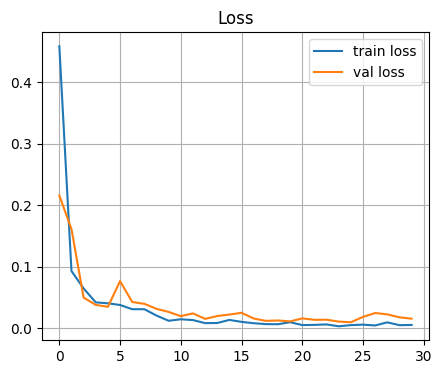

In [13]:
import matplotlib.pyplot as plt

def plot_history(history, save_path="loss_plot.png"):
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(history.history["loss"], label="train loss")
    ax.plot(history.history["val_loss"], label="val loss")
    ax.set_title("Loss")
    ax.legend()
    ax.grid()
    
    # Simpan plot ke file PNG dengan path default
    plt.savefig(save_path, format='png', dpi=300)
    print(f"Plot saved to {save_path}")
    
    # Tampilkan plot
    plt.show()
    

plot_history(history)

Plot saved to accuracy_plot.png


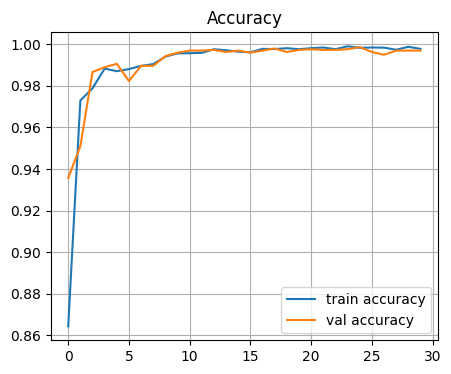

In [14]:
def plot_history(history, save_path="accuracy_plot.png"):
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(history.history["accuracy"], label="train accuracy")
    ax.plot(history.history["val_accuracy"], label="val accuracy")
    ax.set_title("Accuracy")
    ax.legend()
    ax.grid()
    
    # Simpan plot ke file PNG dengan path default
    plt.savefig(save_path, format='png', dpi=300)
    print(f"Plot saved to {save_path}")
    
    # Tampilkan plot
    plt.show()
    

plot_history(history)

## Evaluasi model

In [15]:
def create_test_generator(test_dataset_path, mapping, img_height=224, img_width=224, batch_size=32):
    """
    Membuat test data generator tanpa augmentasi
    """
    # Data generator untuk test (hanya rescaling, tanpa augmentasi)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Test generator
    test_generator = test_datagen.flow_from_directory(
        test_dataset_path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        classes=mapping['classes'],  # Gunakan urutan class yang sama dengan training
        class_mode='categorical',
        shuffle=False  # Jangan shuffle untuk konsistensi evaluasi
    )
    
    return test_generator

In [16]:
test_generator = create_test_generator(
        test_dataset_path=test_dataset_path,
        mapping=mapping,
        img_height=224,
        img_width=224,
        batch_size=256
    )

Found 3000 images belonging to 15 classes.


In [17]:
# Evaluasi model pada test set
if test_generator is not None:
    
    # Evaluasi
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
    
    # Tampilkan hasil
    print("\n" + "="*50)
    print("📊 HASIL EVALUASI TEST SET")
    print("="*50)
    print(f"🎯 Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"📉 Test Loss: {test_loss:.4f}")
    print("="*50)
        
else:
    print("❌ Tidak dapat melakukan evaluasi karena test generator tidak tersedia")

12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9985 - loss: 0.0068

📊 HASIL EVALUASI TEST SET
🎯 Test Accuracy: 0.9980 (99.80%)
📉 Test Loss: 0.0099


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generate predictions for detailed analysis
test_generator.reset()  # Reset generator
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes[:len(y_pred_classes)]  # Match prediction length

print("🔍 Generating detailed evaluation metrics...")
print(f"📊 Predictions shape: {y_pred.shape}")
print(f"🎯 True labels shape: {len(y_true)}")
print(f"✅ Data prepared for evaluation")

12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step
🔍 Generating detailed evaluation metrics...
📊 Predictions shape: (3000, 15)
🎯 True labels shape: 3000
✅ Data prepared for evaluation


In [19]:
# Classification Report
print("📋 CLASSIFICATION REPORT")
print("="*80)
class_names = mapping['classes']
report = classification_report(y_true, y_pred_classes, 
                             target_names=class_names, 
                             output_dict=True)

# Print formatted report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Convert to DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()
print("\n📊 Classification Report (DataFrame):")
print(report_df.round(4))

📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Bean       1.00      1.00      1.00       200
Bitter_Gourd       1.00      0.99      1.00       200
Bottle_Gourd       1.00      1.00      1.00       200
     Brinjal       0.99      1.00      1.00       200
    Broccoli       1.00      1.00      1.00       200
     Cabbage       1.00      1.00      1.00       200
    Capsicum       1.00      1.00      1.00       200
      Carrot       1.00      1.00      1.00       200
 Cauliflower       1.00      0.99      0.99       200
    Cucumber       1.00      0.99      1.00       200
      Papaya       1.00      0.99      1.00       200
      Potato       1.00      1.00      1.00       200
     Pumpkin       0.99      1.00      1.00       200
      Radish       1.00      1.00      1.00       200
      Tomato       1.00      0.99      1.00       200

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
we

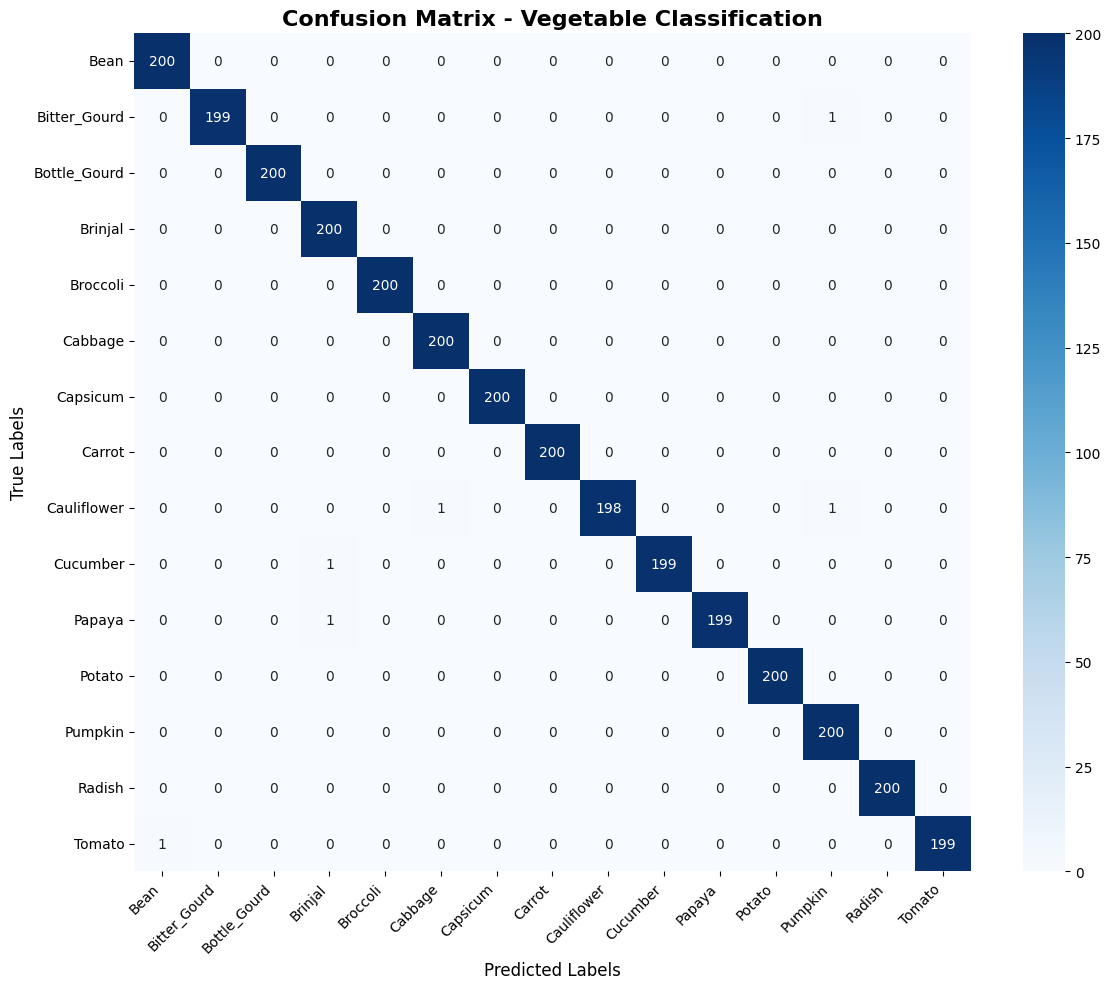


📈 CONFUSION MATRIX ANALYSIS
📊 Matrix shape: (15, 15)
🎯 Total samples: 3000
✅ Correct predictions: 2994
❌ Incorrect predictions: 6
🎲 Overall Accuracy: 0.9980 (99.80%)


In [20]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Vegetable Classification', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Print confusion matrix statistics
print("\n📈 CONFUSION MATRIX ANALYSIS")
print("="*50)
print(f"📊 Matrix shape: {cm.shape}")
print(f"🎯 Total samples: {cm.sum()}")
print(f"✅ Correct predictions: {np.trace(cm)}")
print(f"❌ Incorrect predictions: {cm.sum() - np.trace(cm)}")
print(f"🎲 Overall Accuracy: {np.trace(cm)/cm.sum():.4f} ({np.trace(cm)/cm.sum()*100:.2f}%)")

## Konversi Model

In [21]:
model.load_weights('/kaggle/working/best_model.keras')

In [22]:
# Define working directory and saved model directory
work_dir = '/kaggle/working/'
saved_model_dir = os.path.join(work_dir, 'saved_model')

# Create the directory if it doesn't exist
os.makedirs(saved_model_dir, exist_ok=True)

# Save the model in SavedModel format
tf.saved_model.save(model, saved_model_dir)

In [23]:
# Convert the SavedModel to TFLite format
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = os.path.join(work_dir, 'best_model.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved at: {tflite_model_path}")

W0000 00:00:1753010146.934248      19 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1753010146.934290      19 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1753010147.176794      19 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


TFLite model saved at: /kaggle/working/best_model.tflite


In [24]:
pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.5.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
pandas-gbq 0.29.1 requires google-api-core<3.0.0,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
plot

In [25]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model /kaggle/working/saved_model /kaggle/working/tfjs_model

2025-07-20 11:15:58.914064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753010158.935458     818 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753010158.941946     818 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
I0000 00:00:1753010172.705819     818 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6473 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1753010183.613849     818 devices.cc:67] Number of eligible GPUs (core cou

## Inference (Optional)

In [26]:
# Load SavedModel untuk inference
saved_model_path = '/kaggle/working/saved_model'
loaded_model = tf.saved_model.load(saved_model_path)

# Fungsi inference dengan loaded model
def inference_with_saved_model(loaded_model, image_path, mapping_path="/kaggle/working/class_mapping.json"):
    """
    Inference menggunakan SavedModel yang sudah disimpan
    """
    # Load mapping
    mapping = load_class_mapping(mapping_path)
    
    # Load dan preprocess gambar
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    img_tensor = tf.constant(img_array)
    
    # Prediksi menggunakan loaded model
    infer = loaded_model.signatures["serving_default"]
    prediction = infer(tf.cast(img_tensor, tf.float32))
    
    # Extract prediction results (adjust key name if needed)
    pred_values = list(prediction.values())[0].numpy()
    predicted_idx = np.argmax(pred_values)
    predicted_class = mapping['idx_to_class'][str(predicted_idx)]
    confidence = np.max(pred_values)
    
    return predicted_class, confidence, pred_values

print("✅ SavedModel berhasil dimuat!")
print(f"📁 Model path: {saved_model_path}")

✅ SavedModel berhasil dimuat!
📁 Model path: /kaggle/working/saved_model


🔍 Melakukan inference dengan SavedModel...
📷 Image path: /kaggle/input/inference-test/potato_inference.jpg
--------------------------------------------------
 Mapping loaded dari: /kaggle/working/class_mapping.json
📊 HASIL INFERENCE DENGAN SAVEDMODEL:
🎯 Prediksi: Potato
🎲 Confidence: 0.7909 (79.09%)
--------------------------------------------------


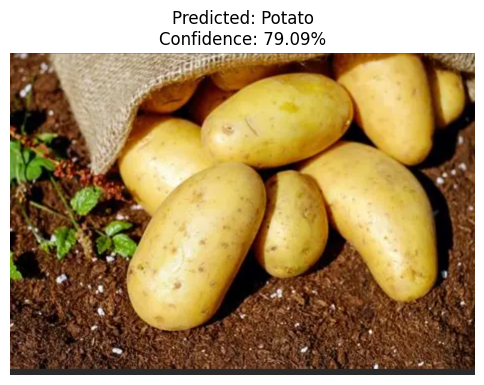

✅ Inference dengan SavedModel BERHASIL!


In [27]:
# Test inference dengan SavedModel
image_path = '/kaggle/input/inference-test/potato_inference.jpg'

print("🔍 Melakukan inference dengan SavedModel...")
print(f"📷 Image path: {image_path}")
print("-" * 50)

try:
    predicted_class, confidence, pred_values = inference_with_saved_model(loaded_model, image_path)
    
    print("📊 HASIL INFERENCE DENGAN SAVEDMODEL:")
    print(f"🎯 Prediksi: {predicted_class}")
    print(f"🎲 Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
    print("-" * 50)
    
    # Tampilkan gambar untuk verifikasi
    img = Image.open(image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence*100:.2f}%")
    plt.axis('off')
    plt.show()
    
    print("✅ Inference dengan SavedModel BERHASIL!")
    
except Exception as e:
    print(f"❌ Error dalam inference: {e}")
    print("Mencoba dengan metode alternatif...")